In [5]:
#@title Mount Drive
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Machine-Learning-Optimization

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Machine-Learning-Optimization_working


In [21]:
!pip install barbar

#@title Import and utilities 

from Frank_Wolfe.utils.utils import *
from Frank_Wolfe.DFW import *
from Frank_Wolfe.architectures import *
from Frank_Wolfe.MultiClassHingeLoss import *
from barbar import Bar
import torch
import torch.nn as nn
import torchvision
import os
import time
import pickle
import sys
from torch.optim.lr_scheduler import StepLR
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


device = "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#@title Choose dataset name and architecture of the network 

# Select the dataset and the architecture

dataset_name = 'CIFAR10' #@param ['CIFAR10', 'CIFAR100']
model_type = 'WideResNet' #@param ['DenseNet', 'WideResNet', 'GoogLeNet']

# load the model
if model_type == 'GoogLeNet':
    model = GoogleNet(num_class=10 if dataset_name == "CIFAR10" else 100)
elif model_type == 'DenseNet':
    model = torchvision.models.densenet121(pretrained=False)
elif model_type == 'WideResNet':
    model =  WideResNet(num_classes=10 if dataset_name == "CIFAR10" else 100)
else:
    raise ValueError("Please, select an available architecture")

# setting dataset attributes, dictionary useful to normalize the images
datasetDict = setDatasetAttributes(dataset_name)
# transform operation
trainTransformDict, testTransformDict = setTrainAndTest(dataset_name) 
root = f"{dataset_name}-dataset"

# prepare train and test datasets 
trainData = datasetDict['datasetDict'](root=root, train=True, download=True,
                                            transform=trainTransformDict[dataset_name])
testData = datasetDict['datasetDict'](root=root, train=False,
                                        transform=testTransformDict[dataset_name])
# move the model to GPU
model = model.to(device="cuda:0")

  0%|          | 0/170498071 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#@title Choose optimizer and parameters 

# Choice of the optimizer and the parameters.

# The parameters used in our experiments can be found
# both in the report and at the end of the notebook.

optimizer_name = "DFW multistep" #@param  ['DFW', 'Adam', 'SGD with scheduler', 'DFW multistep']
eta =   0.1 #@param {type:"number"}
momentum = 0.9 #@param {type:"number"}
lr = 0.001 #@param {type:"number"}
beta_1 = 0.9 #@param {type:"number"}
beta_2 = 0.999 #@param {type:"number"}
initial_prox_steps = 2 #@param {type: "number"}

if optimizer_name != "DFW multistep":
    initial_prox_steps = 1

# define the optimizer

if optimizer_name == "DFW" or optimizer_name == 'DFW multistep':
    optimizer = DFW(params=model.parameters(), eta=eta, momentum=momentum,
                    prox_steps=initial_prox_steps)
    
    assert initial_prox_steps > 0
    assert eta > 0
    assert 0 <= momentum <= 1
elif optimizer_name == "SGD with scheduler":
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr,
                              momentum=momentum)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
    assert 0 <= momentum <= 1
elif optimizer_name == "Adam":
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, 
                               betas=(beta_1, beta_2))
    
if optimizer_name == "DFW" or optimizer_name == "DFW multistep":
    # we consider a convex and piece-wise linear objective for DFW
    loss_criterion = MultiClassHingeLoss().to(device="cuda:0")
    # smoothening of the loss function for many classes
    smoothing = True
else: 
    # cross entropy otherwise
    loss_criterion = nn.CrossEntropyLoss().to(device="cuda:0")
    smoothing = False

In [ ]:
#@title Train the network  

# we will append our results on these lists
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
epochs_times = []

# parameters for the training phase
nepochs = 50 #@param {type:"integer"}
batch_size = 128  #@param {type:"integer"}
verbose = 0 #@param [0, 1]

# Loaders
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batch_size, shuffle=True,
                                      pin_memory=torch.cuda.is_available(), num_workers=2)
testLoader = torch.utils.data.DataLoader(testData, batch_size=batch_size, shuffle=False,
                                      pin_memory=torch.cuda.is_available(), num_workers=2)

# initialize necessary metrics objects
train_loss, train_accuracy = AverageMeter(), AverageMeter()
test_loss, test_accuracy = AverageMeter(), AverageMeter()

# function to reset metrics
def reset_metrics():
    train_loss.reset()
    train_accuracy.reset()
    test_loss.reset()
    test_accuracy.reset()

@torch.no_grad()
def evaluate_model(data="train"):
    if data == "train":
        loader = trainLoader
        mean_loss, mean_accuracy = train_loss, train_accuracy
    elif data == "test":
        loader = testLoader
        mean_loss, mean_accuracy = test_loss, test_accuracy
    
    sys.stdout.write(f"Evaluation of {data} data:\n")
    
    # iteration over the dataset
    for x_input, y_target in Bar(loader):
        x_input, y_target = x_input.to(device="cuda:0"), y_target.to(device="cuda:0") # we move to GPU
        output = model.eval()(x_input)
        loss = loss_criterion(output, y_target)
        
        # update metrics
        mean_loss(loss.item(), len(y_target)) 
        mean_accuracy(Utilities.categorical_accuracy(y_true=y_target, output=output), len(y_target))

    
# Training
for epoch in range(nepochs + 1):
    
    start = time.time() # start to time
    reset_metrics() # reset the metrics from the previous epoch
    sys.stdout.write(f"\n\nEpoch {epoch}/{nepochs}\n")
    
    if epoch == 0:
        # First pass through the network to evaluate the model once to get the metrics
        evaluate_model(data='train')
    else:
        if epoch > int(0.2 * nepochs) and optimizer_name == "DFW multistep" and asymptotic_prox_steps_num >1:
            
            # if we already finished the first 20% of the epochs we continue with single steps
            optimizer.prox_steps = 1
            
        sys.stdout.write(f"Training:\n")
        for x_input, y_target in Bar(trainLoader):
            x_input, y_target = x_input.to(device="cuda:0"), y_target.to(device="cuda:0")
            optimizer.zero_grad()  # Zero the gradient buffers
            output = model.train()(x_input) # compute the output
            if dataset_name == "CIFAR100" and smoothing:
              # smoothing of the loss for DFW
              with set_smoothing_enabled(True):
                loss = loss_criterion(output, y_target) # compute the loss
            else:
                loss = loss_critertion(output, y_target) # without smoothing
            loss.backward()  # Backpropagation
            if optimizer_name == "DFW" or optimizer_name == 'DFW multistep':
                optimizer.step(lambda: float(loss))
            else:
                optimizer.step() 
            train_loss(loss.item(), len(y_target))
            train_accuracy(Utilities.categorical_accuracy(y_true=y_target, output=output), len(y_target))

    if optimizer_name == "SGD with scheduler":
        scheduler.step()

    # evalutate the model on the test set    
    evaluate_model(data='test')
    sys.stdout.write(f"\n Finished epoch {epoch}/{nepochs}: Train Loss {train_loss.result()} | Test Loss {test_loss.result()} | Train Acc {train_accuracy.result()} | Test Acc {test_accuracy.result()}\n")



Epoch 0/50
Evaluation of train data:
50000/50000: [===============================>] - ETA 0.7s
Evaluation of test data:
10000/10000: [===============================>] - ETA 0.3s

 Finished epoch 0/50: Train Loss 1.1074069875717163 | Test Loss 1.097416378211975 | Train Acc 0.09998 | Test Acc 0.1002
Time elapsed for the current epoch 116.83940601348877

Epoch 1/50
Training:
50000/50000: [===============================>] - ETA 0.9s
Evaluation of test data:
10000/10000: [===============================>] - ETA 0.3s

 Finished epoch 1/50: Train Loss 1.2463369568252562 | Test Loss 1.0503244495391846 | Train Acc 0.13936 | Test Acc 0.1632
Time elapsed for the current epoch 331.5416555404663

Epoch 2/50
Training:
50000/50000: [===============================>] - ETA 0.9s
Evaluation of test data:
10000/10000: [===============================>] - ETA 0.3s

 Finished epoch 2/50: Train Loss 1.0777584143829346 | Test Loss 1.0660836534500122 | Train Acc 0.16654 | Test Acc 0.226
Time elapsed for 

KeyboardInterrupt: ignored

# Parameters used in the report

In order to reproduce our results (i.e. the training trends shown in the report), the following set of parameters should be used.\
If not specified otherwise, the remaining parameters (e.g. the stability perturbation $\epsilon$ for Adam and Adagrad) are set to their default values.


$\text{Deep Frank Wolfe (single step and multistep)}$:
```python
eta = 0.1  # proximal coefficient
momentum = 0.9  # momentum parameter
optimizer = DFW(model.parameters(), eta=eta, 
            momentum=momentum, prox_steps=2) # or prox_steps=1
```

$\textbf{Stochastic Gradient Descent with scheduler}$:
```python
lr = 0.1  # learning rate
momentum = 0.9  # momentum parameter
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr,
                              momentum=momentum)
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)  # define scheduler
```

$\textbf{Adam}$:
```python
lr = 0.001 # learning rate
beta_1 = 0.9
beta_2 = 0.999
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr, 
                               betas=(beta_1, beta_2))
```

C:\Users\Federico Betti\Documents\GitHub\Machine-Learning-Optimization_new\Frank_Wolfe\utils\utils.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_losses = np.array([stats_dict_list[i][list_optimizers_tilda[i]]['train_losses']


ValueError: x and y must have same first dimension, but have shapes (51,) and (39,)

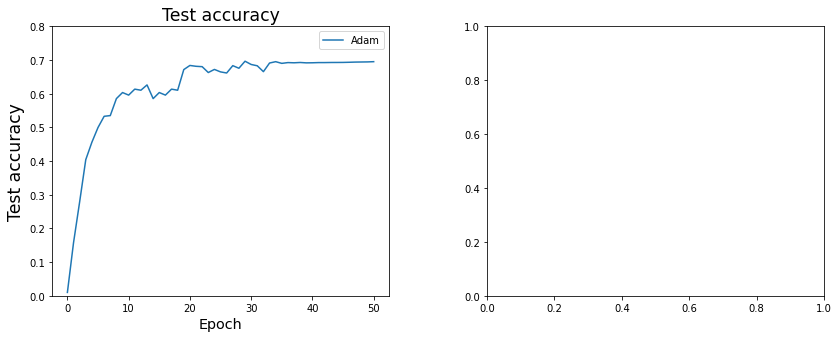

In [20]:
dataset_name = 'CIFAR100' #@param ['CIFAR10', 'CIFAR100']
model_type = 'GoogLeNet' #@param ['DenseNet', 'WideResNet', 'GoogLeNet']
plot_stats(dataset_name, model_type)